# Einleitung

Das Notebook soll mehrere Aspekte bei der Sensordatenfusion zeigen:
- eine einfache Mittelwertbildung bei zwei Sensoren bringt keinen Mehrwehrt, wenn z.B. beide Sensoren in die gleiche Richtung verzerrt sind (Bias z.B. beide Male positiv oder beide Male negativ).
- wir können aber den Bias eines Sensors experimentell schätzen und vor der Fusion eine Biaskorrektur durchführen. Der Bias-korrigierte Mittelwertschätzer ist dann im Mittel besser als die isoliert betrachteten Bias-korrigierten Sensorwerte.
- wenn die Sensorwerte nicht direkt Schätzungen in der benötigten Einheit zurück liefern, ist aber die Verwendung eines inversen Sensormodells (ISM) möglich. Während ein Sensormodell beschreibt, welchen Messwert ein Sensor in einer Situation liefert, beschreibt das inverse Sensormodell hingegen basierend auf dem Messwert eines Sensors, wie die Situation in der Welt wahrscheinlich war.
- eine einfache Möglichkeit ein ISM zu realisieren ist eine Look-Up-Tabelle zu speichern von <Sensorwert, Distanz> Paaren.
- bei der Fusion mittels eines Inversen Sensormodells benötigen wir keine Bias-Korrektur mehr, denn wir haben eine Abbildung von Sensorwerte auf tatsächliche Abstände gelernt.
- gerade bei Mehrdeutigkeiten in den Sensordaten kann ein Machine Learning Ansatz helfen, die Mehrdeutigkeiten durch mehrere Sensoren aufzulösen
- hierbei ist das Machine Learning Modell, das wir erlernen, ebenso ein Inverses Sensormodell, das mehrere Messwerte - zusammengefasst in einem Messwertvektor z - auf eine Schätzung lernt abzubilden
- ein besonderes interessanter Fall ist hierbei, dass die Messwerte der Sensoren auch aus sehr unterschiedlichen Bereichen kommen. Dann ist bei vielen Machine Learning Ansätzen eine vorherige Normalisierung der Messwerte notwendig!

# Erzeugen von Zufallszahlen

## Normalverteilte Zufallszahlen

In [1]:
import numpy

In [2]:
numpy.random.seed(42)

In [3]:
numpy.random.normal(loc=0, scale=1.0)

0.4967141530112327

In [4]:
A = numpy.random.normal(loc=3, scale=1.0, size=(10000))
A[:5]

array([2.8617357 , 3.64768854, 4.52302986, 2.76584663, 2.76586304])

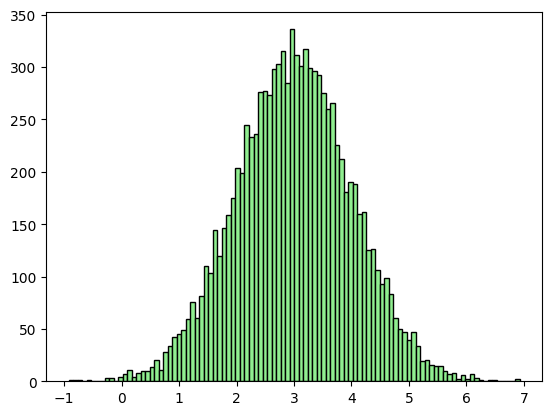

In [5]:
import matplotlib.pyplot as plt
plt.hist(A, bins=100, color="lightgreen", edgecolor="black")
plt.show()

## Gleichverteilte Zufallszahlen

In [6]:
numpy.random.uniform(low=-10, high=+10)

-8.563849091090617

In [7]:
A = numpy.random.uniform(low=-10, high=+10, size=(10000))
A[:5]

array([-8.11448044,  1.65738722, -8.96675648, -3.2614625 ,  5.06399404])

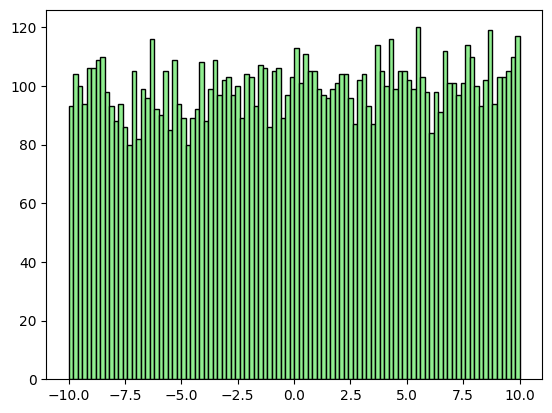

In [8]:
import matplotlib.pyplot as plt
plt.hist(A, bins=100, color="lightgreen", edgecolor="black")
plt.show()

# Simulation eines Abstandssensors mit linearer Kennlinie

## Eine Sensorklasse

In [9]:
class abstandssensor_lineare_kennlinie:
    
    def __init__(self):
        self.bias = numpy.random.uniform(low=-10, high=+10)
        self.noise = numpy.random.uniform(low=1, high=5)
        
    def gib_mir_sensorwert(self, abstand):
        sensorwert = abstand + numpy.random.normal(loc=self.bias, scale=self.noise)
        return sensorwert
    
    def gib_mir_kennlinien_daten(self):
        abstaende = []
        sensorwerte = []
        for abstand in range(0,101):
            sensorwert = self.gib_mir_sensorwert(abstand)
            abstaende.append(abstand)
            sensorwerte.append(sensorwert)
        return abstaende, sensorwerte
    
    def zeige_sensor_kurve(self):
        abstaende, sensorwerte = self.gib_mir_kennlinien_daten()
        plt.plot(abstaende,sensorwerte)
        plt.xlabel("Tatsächlicher Abstand (Grundwahrheit)")
        plt.ylabel("Sensorwert")
        plt.show()        

In [10]:
s1 = abstandssensor_lineare_kennlinie()

In [11]:
s1.gib_mir_sensorwert(100)

104.9649320661258

In [12]:
s1.bias

5.615756919595849

In [13]:
s1.noise

2.1303633301501295

In [14]:
s2 = abstandssensor_lineare_kennlinie()

In [15]:
s2.gib_mir_sensorwert(100)

95.47167729960418

In [16]:
s2.bias

1.2788353928897394

In [17]:
s2.noise

2.617304491397915

## Sensorkurven

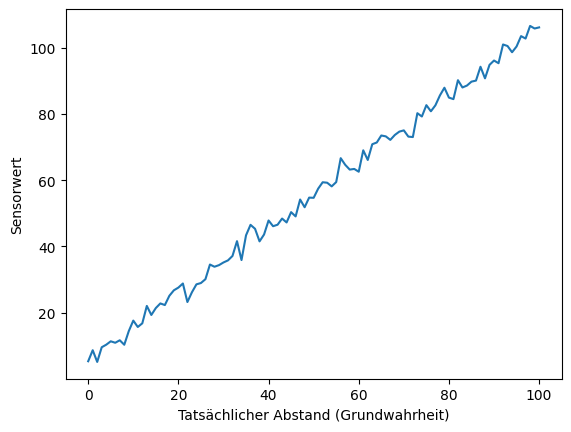

In [18]:
s1.zeige_sensor_kurve()

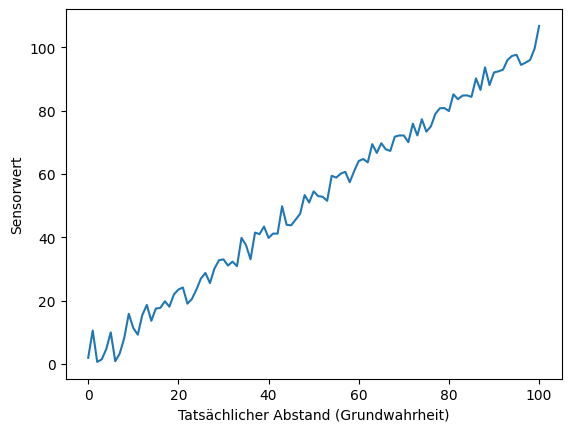

In [19]:
s2.zeige_sensor_kurve()

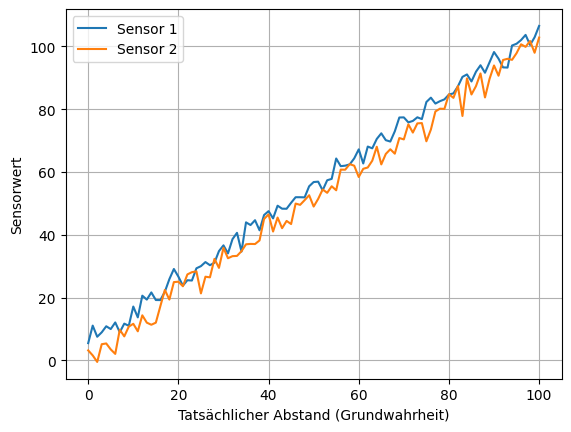

In [20]:
a1,sw1 = s1.gib_mir_kennlinien_daten()
a2,sw2 = s2.gib_mir_kennlinien_daten()
plt.plot(a1,sw1, label="Sensor 1")
plt.plot(a2,sw2, label="Sensor 2")
plt.xlabel("Tatsächlicher Abstand (Grundwahrheit)")
plt.ylabel("Sensorwert")
plt.legend()
plt.grid()
plt.show() 

# Fehlerfunktion für Fusionsergebnisse

In [21]:
gw = numpy.array([1,2,3,4,5])
sensorwerte = numpy.array([0.5, 2.5, 2.5, 4.5, 5.5])

In [22]:
numpy.mean(abs(gw - sensorwerte))

0.5

In [23]:
numpy.around( [0.009, 1.777, 2.12345, 3.567], 2 )

array([0.01, 1.78, 2.12, 3.57])

In [24]:
def MAE(gw, sensorwerte):
    MAE = numpy.mean(abs(gw - sensorwerte))
    return numpy.around(MAE,2)

In [25]:
MAE(gw, sensorwerte)

0.5

# Erster Versuch eines Fusionsansatzes (Mittelwertbildung)

## Fehler bei Verwendung nur von Sensor 1

In [26]:
def erzeuge_messreihe(s, N):
    gw = []
    sensorwerte = []
    for abstand in range(0,N):
        sensorwert = s.gib_mir_sensorwert(abstand)
        gw.append(abstand)
        sensorwerte.append(sensorwert)
        
    return numpy.array(gw), numpy.array(sensorwerte)

In [27]:
gw, sensorwerte1 = erzeuge_messreihe(s1,1000)

In [28]:
gw.shape

(1000,)

In [29]:
sensorwerte1.shape

(1000,)

In [30]:
gw[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
sensorwerte1[:10]

array([ 6.65828214,  9.01005797,  5.14880548, 10.90293692,  7.74281829,
       15.60217756,  9.72298882, 10.13010482, 12.99687538, 16.84915503])

In [32]:
MAE(gw, sensorwerte1)

5.65

In [33]:
s1.bias

5.615756919595849

## Fehler bei Verwendung nur von Sensor 2

In [34]:
gw, sensorwerte2 = erzeuge_messreihe(s2, 1000)

In [35]:
gw[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
sensorwerte2[:10]

array([-0.32129466,  6.04534689,  3.71394602,  4.44660925,  0.59464221,
        8.00073158,  7.52762871,  8.7346331 ,  9.03521928, 11.9151628 ])

In [37]:
MAE(gw, sensorwerte2)

2.39

In [38]:
s2.bias

1.2788353928897394

## Sensorfusion über einfache Mittelwertbildung bringt es i.d.R. nicht!

In [39]:
sensorwerte1[:10]

array([ 6.65828214,  9.01005797,  5.14880548, 10.90293692,  7.74281829,
       15.60217756,  9.72298882, 10.13010482, 12.99687538, 16.84915503])

In [40]:
sensorwerte2[:10]

array([-0.32129466,  6.04534689,  3.71394602,  4.44660925,  0.59464221,
        8.00073158,  7.52762871,  8.7346331 ,  9.03521928, 11.9151628 ])

In [41]:
sensorwerte_fusioniert = (sensorwerte1+sensorwerte2)/2
sensorwerte_fusioniert[:10]

array([ 3.16849374,  7.52770243,  4.43137575,  7.67477309,  4.16873025,
       11.80145457,  8.62530877,  9.43236896, 11.01604733, 14.38215892])

In [42]:
MAE(gw, sensorwerte_fusioniert)

3.51

# Zweiter Versuch eins Fusionsansatzes (Mittelwertbildung + Biaskorrektur)

In [43]:
# Wie kann man den Bias korrigieren?
# Experimentell: durch Berechnung der mittleren Abweichung
def ME(gw, sensorwerte):
    ME = numpy.mean(gw - sensorwerte)
    return ME

In [44]:
bias1 = ME(gw,sensorwerte1)
bias1

-5.653038712547346

In [45]:
bias2 = ME(gw,sensorwerte2)
bias2

-1.3228686374432386

In [46]:
sensorwerte1[:5]

array([ 6.65828214,  9.01005797,  5.14880548, 10.90293692,  7.74281829])

In [47]:
(sensorwerte1+bias1)[:5]

array([ 1.00524343,  3.35701926, -0.50423323,  5.24989821,  2.08977958])

In [48]:
MAE(gw, sensorwerte1+bias1)

1.68

In [49]:
MAE(gw, sensorwerte2+bias2)

2.13

In [50]:
sensorwerte_fusioniert = ((sensorwerte1+bias1) + (sensorwerte2+bias2))/2

In [51]:
MAE(gw,sensorwerte_fusioniert)

1.34

# Experiment: Immer mehr Sensoren

In [52]:
def exp(ANZ_SENSOREN=3, zeige_details=True) -> float:

    # 1. Erzeuge Sensoren
    alle_sensoren = []
    for sid in range(ANZ_SENSOREN):
        s = abstandssensor_lineare_kennlinie()
        if zeige_details:
            print(f"Sensor #{sid}: bias={s.bias:.2f}, noise={s.noise:.2f}")
        alle_sensoren.append( s )

    # 2. Simuliere Messungen zur Bestimmung der Biaskorrekturwerte
    #    und bereite Sensor-spezifische Bias-Korrekturwerte vor
    alle_biase = []
    for sid in range(ANZ_SENSOREN):
        gw, sensorwerte = erzeuge_messreihe(alle_sensoren[sid],1000)
        bias = ME(gw,sensorwerte)
        alle_biase.append( bias )

    # 3. Simuliere jetzt Messungen in der Anwendung
    alle_sensorwerte = []
    for sid in range(ANZ_SENSOREN):
        gw, sensorwerte = erzeuge_messreihe(alle_sensoren[sid],1000)
        alle_sensorwerte.append( sensorwerte )
        if zeige_details:            
            print(f"Fehler bei Verwendung nur von Sensor #{sid}: {MAE(gw,sensorwerte)}")

    # 4. Fusion
    fusionierte_werte = numpy.zeros(1000)
    for sid in range(ANZ_SENSOREN):
        fusionierte_werte += alle_sensorwerte[sid] + alle_biase[sid]
    fusionierte_werte /= ANZ_SENSOREN
    fusionsfehler = MAE(gw,fusionierte_werte)
    print(f"Fehler bei Fusion mit {ANZ_SENSOREN} Sensoren: {fusionsfehler}")
    
    return fusionsfehler

exp(3)
#exp(3, zeige_details=False)

Sensor #0: bias=-9.03, noise=3.81
Sensor #1: bias=9.56, noise=2.79
Sensor #2: bias=-4.81, noise=1.63
Fehler bei Verwendung nur von Sensor #0: 9.02
Fehler bei Verwendung nur von Sensor #1: 9.48
Fehler bei Verwendung nur von Sensor #2: 4.76
Fehler bei Fusion mit 3 Sensoren: 1.27


1.27

Fehler bei Fusion mit 1 Sensoren: 1.22
Fehler bei Fusion mit 2 Sensoren: 1.76
Fehler bei Fusion mit 3 Sensoren: 1.16
Fehler bei Fusion mit 4 Sensoren: 0.86
Fehler bei Fusion mit 5 Sensoren: 1.15
Fehler bei Fusion mit 6 Sensoren: 1.07
Fehler bei Fusion mit 7 Sensoren: 0.88
Fehler bei Fusion mit 8 Sensoren: 1.12
Fehler bei Fusion mit 9 Sensoren: 0.79
Fehler bei Fusion mit 10 Sensoren: 0.94
Fehler bei Fusion mit 11 Sensoren: 0.83
Fehler bei Fusion mit 12 Sensoren: 0.72
Fehler bei Fusion mit 13 Sensoren: 0.68
Fehler bei Fusion mit 14 Sensoren: 0.67
Fehler bei Fusion mit 15 Sensoren: 0.57
Fehler bei Fusion mit 16 Sensoren: 0.62
Fehler bei Fusion mit 17 Sensoren: 0.57
Fehler bei Fusion mit 18 Sensoren: 0.7
Fehler bei Fusion mit 19 Sensoren: 0.56


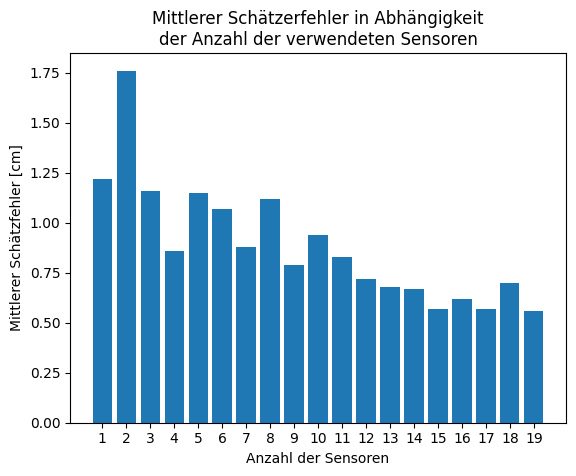

In [53]:
sensoranzahlen = []
alle_fusionsfehler = []
for ANZ_SENSOREN in range(1,20):
    fusionsfehler = exp(ANZ_SENSOREN, zeige_details=False)
    sensoranzahlen.append(ANZ_SENSOREN)
    alle_fusionsfehler.append( fusionsfehler )

import matplotlib.pyplot as plt
plt.bar(sensoranzahlen, alle_fusionsfehler)
plt.xlabel("Anzahl der Sensoren")
plt.ylabel("Mittlerer Schätzfehler [cm]")
plt.xticks(sensoranzahlen)
plt.title("Mittlerer Schätzerfehler in Abhängigkeit\n" +
          "der Anzahl der verwendeten Sensoren")
plt.show()

# Simulation eines Abstandssensors mit nicht-linearer Kennlinie

## Der Logarithmus ist eine nicht-lineare Funktion

In [54]:
x = numpy.arange(1,1001)
x[:100]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [55]:
y = numpy.log(x)
y[:100]

array([0.        , 0.69314718, 1.09861229, 1.38629436, 1.60943791,
       1.79175947, 1.94591015, 2.07944154, 2.19722458, 2.30258509,
       2.39789527, 2.48490665, 2.56494936, 2.63905733, 2.7080502 ,
       2.77258872, 2.83321334, 2.89037176, 2.94443898, 2.99573227,
       3.04452244, 3.09104245, 3.13549422, 3.17805383, 3.21887582,
       3.25809654, 3.29583687, 3.33220451, 3.36729583, 3.40119738,
       3.4339872 , 3.4657359 , 3.49650756, 3.52636052, 3.55534806,
       3.58351894, 3.61091791, 3.63758616, 3.66356165, 3.68887945,
       3.71357207, 3.73766962, 3.76120012, 3.78418963, 3.80666249,
       3.8286414 , 3.8501476 , 3.87120101, 3.8918203 , 3.91202301,
       3.93182563, 3.95124372, 3.97029191, 3.98898405, 4.00733319,
       4.02535169, 4.04305127, 4.06044301, 4.07753744, 4.09434456,
       4.11087386, 4.12713439, 4.14313473, 4.15888308, 4.17438727,
       4.18965474, 4.20469262, 4.21950771, 4.2341065 , 4.24849524,
       4.26267988, 4.27666612, 4.29045944, 4.30406509, 4.31748

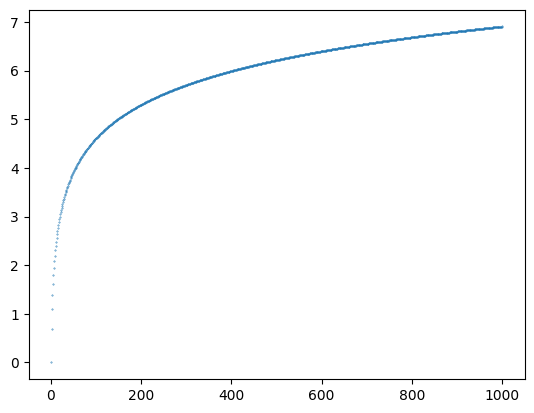

In [56]:
plt.scatter(x,y, marker=".", s=0.5)
#plt.plot(x,y)
plt.show()

## Eine neue Sensor-Klasse

In [57]:
class abstandssensor_nichtlineare_kennlinie:
    
    def __init__(self):
        self.bias = numpy.random.uniform(low=-500, high=+500)
        self.noise = numpy.random.uniform(low=1, high=100)
        
    def gib_mir_sensorwert(self, abstand):
        sensorwert = abstand + numpy.random.normal(loc=self.bias, scale=self.noise) + \
                     500*numpy.log(1+abstand)
        return sensorwert
    
    def gib_mir_kennlinien_daten(self):
        abstaende = []
        sensorwerte = []
        for abstand in range(0,101):
            sensorwert = self.gib_mir_sensorwert(abstand)
            abstaende.append(abstand)
            sensorwerte.append(sensorwert)
        return abstaende, sensorwerte
    
    def zeige_sensor_kurve(self):
        abstaende, sensorwerte = self.gib_mir_kennlinien_daten()
        plt.plot(abstaende,sensorwerte)
        plt.xlabel("Tatsächlicher Abstand (Grundwahrheit)")
        plt.ylabel("Sensorwert")
        plt.show()         

In [58]:
numpy.random.seed(42)

In [59]:
s1 = abstandssensor_nichtlineare_kennlinie()

In [60]:
s1.bias, s1.noise

(-125.45988115263754, 95.1207163345817)

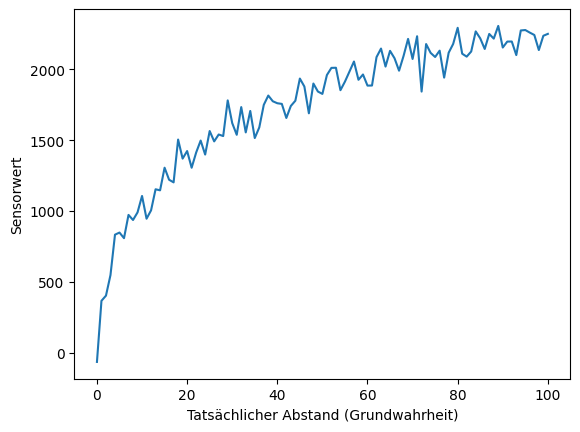

In [61]:
s1.zeige_sensor_kurve()

In [62]:
s2 = abstandssensor_nichtlineare_kennlinie()

In [63]:
s2.bias, s2.noise

(442.90970391251915, 32.99709027005477)

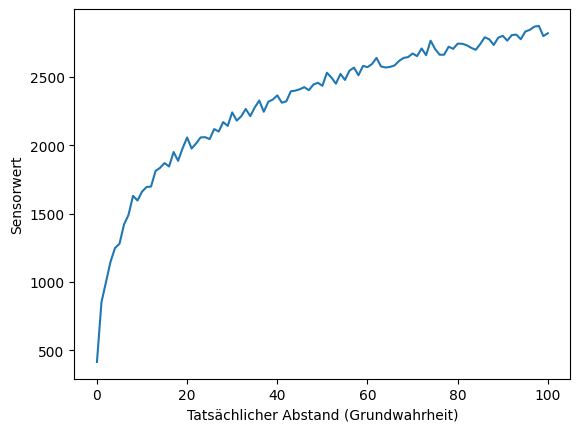

In [64]:
s2.zeige_sensor_kurve()

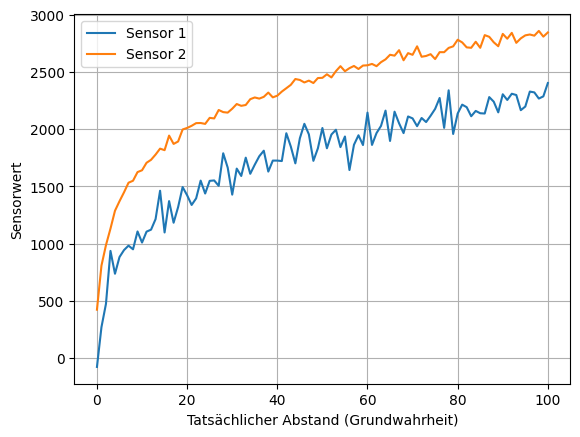

In [65]:
a1,sw1 = s1.gib_mir_kennlinien_daten()
a2,sw2 = s2.gib_mir_kennlinien_daten()
plt.plot(a1,sw1, label="Sensor 1")
plt.plot(a2,sw2, label="Sensor 2")
plt.xlabel("Tatsächlicher Abstand (Grundwahrheit)")
plt.ylabel("Sensorwert")
plt.legend()
plt.grid()
plt.show() 

# Neuer Fusionsansatz

## Experimentelle Bestimmung eines Inversen Sensormodells (ISM)

In [66]:
ism_s1 = {}

for abstand in range(0,1001):
    
    sensorwerte = []
    for run in range(0,50):
        sensorwert = s1.gib_mir_sensorwert(abstand)
        sensorwerte.append( sensorwert )
    mittlerer_sensorwert = numpy.mean(sensorwerte)
    
    ism_s1[mittlerer_sensorwert] = abstand

In [67]:
list(ism_s1.items())[:10]

[(-127.95781502236503, 0),
 (218.87432283665544, 1),
 (403.0598486424861, 2),
 (577.1042963769047, 3),
 (689.9096231144858, 4),
 (764.9925550187679, 5),
 (843.057828814683, 6),
 (932.6542505271183, 7),
 (994.2562890623785, 8),
 (1068.7480373791577, 9)]

In [68]:
liste_sensorwerte_abstaende = list(ism_s1.items())

In [69]:
liste_sensorwerte_abstaende[:5]

[(-127.95781502236503, 0),
 (218.87432283665544, 1),
 (403.0598486424861, 2),
 (577.1042963769047, 3),
 (689.9096231144858, 4)]

In [70]:
sensorwerte = [paar[0] for paar in liste_sensorwerte_abstaende]
sensorwerte[:5]

[-127.95781502236503,
 218.87432283665544,
 403.0598486424861,
 577.1042963769047,
 689.9096231144858]

In [71]:
abstaende = [paar[1] for paar in liste_sensorwerte_abstaende]
abstaende[:5]

[0, 1, 2, 3, 4]

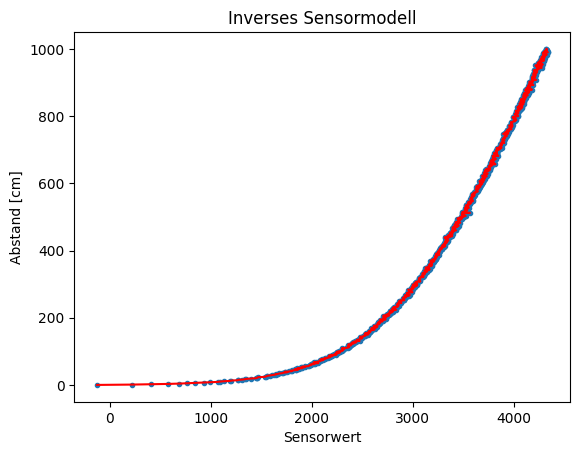

In [72]:
plt.scatter(sensorwerte, abstaende, marker=".")
plt.xlabel("Sensorwert")
plt.ylabel("Abstand [cm]")
plt.title("Inverses Sensormodell")
plt.plot(sensorwerte, abstaende, color="red")
plt.show()

## Eine ISM Hilfsklasse

In [73]:
class ism:
    
    def __init__(self, s):
        self.sensor = s
        self.baue_lut_auf()
        
    def baue_lut_auf(self):        
        self.lut = {}
        for abstand in range(0,1001):
            sensorwerte = []
            for run in range(0,50):
                sensorwert = self.sensor.gib_mir_sensorwert(abstand)
                sensorwerte.append( sensorwert )
            mittlerer_sensorwert = numpy.mean(sensorwerte)
            self.lut[mittlerer_sensorwert] = abstand
            
    def sensorwert_zu_entfernung(self, sensorwert):
        min_dist = None
        best_key = None
        for key in self.lut:
            dist = abs(sensorwert - key)
            if best_key==None or dist < min_dist:
                best_key = key
                min_dist = dist
        
        beste_entfernungs_schaetzung = self.lut[best_key]
        return beste_entfernungs_schaetzung

In [74]:
ism_s1 = ism(s1)
ism_s2 = ism(s2)

In [75]:
ism_s1.sensorwert_zu_entfernung( 1000 )

8

In [76]:
ism_s1.sensorwert_zu_entfernung( 3000 )

295

In [77]:
ism_s1.sensorwert_zu_entfernung( 4000 )

797

In [78]:
ism_s2.sensorwert_zu_entfernung( 1000 )

2

In [79]:
ism_s2.sensorwert_zu_entfernung( 3000 )

128

In [80]:
ism_s2.sensorwert_zu_entfernung( 4000 )

472

## Sensordatenfusion über inverse Sensormodelle

In [81]:
def erzeuge_messreihe_ism(s, s_ism, N):
    gw = []
    schaetzungen = []
    for abstand in range(0,N):
        sensorwert = s.gib_mir_sensorwert(abstand)
        geschaetzer_abstand = s_ism.sensorwert_zu_entfernung( sensorwert )
        gw.append(abstand)
        schaetzungen.append(geschaetzer_abstand)
        
    return numpy.array(gw), numpy.array(schaetzungen)


def exp(ANZ_SENSOREN=3, zeige_details=True) -> float:

    # 1. Erzeuge Sensoren + Inverse Sensormodelle
    alle_sensoren = []
    alle_isms = []
    for sid in range(ANZ_SENSOREN):
        s = abstandssensor_nichtlineare_kennlinie()
        if zeige_details:
            print(f"Sensor #{sid}: bias={s.bias:.2f}, noise={s.noise:.2f}")
        alle_sensoren.append( s )
        alle_isms.append( ism(s) )
    
    # 2. Simuliere jetzt Messungen in der Anwendung
    alle_schaetzungen = []
    for sid in range(ANZ_SENSOREN):
        gw, schaetzungen = erzeuge_messreihe_ism(alle_sensoren[sid],
                                                 alle_isms[sid],
                                                 1000)
        alle_schaetzungen.append( schaetzungen )
        if zeige_details:            
            print(f"Fehler bei Verwendung nur von Sensor #{sid}: {MAE(gw,schaetzungen)}")

    # 4. Fusion
    fusionierte_werte = numpy.zeros(1000)
    for sid in range(ANZ_SENSOREN):
        fusionierte_werte += alle_schaetzungen[sid]
    fusionierte_werte /= ANZ_SENSOREN
    fusionsfehler = MAE(gw, fusionierte_werte)
    print(f"Fehler bei Fusion mit {ANZ_SENSOREN} Sensoren: {fusionsfehler}")
    
    return fusionsfehler

exp(3)
#exp(3, zeige_details=False)

Sensor #0: bias=-254.10, noise=27.99
Sensor #1: bias=-478.71, noise=8.58
Sensor #2: bias=447.58, noise=13.44
Fehler bei Verwendung nur von Sensor #0: 10.18
Fehler bei Verwendung nur von Sensor #1: 3.05
Fehler bei Verwendung nur von Sensor #2: 4.96
Fehler bei Fusion mit 3 Sensoren: 3.93


3.93

Fehler bei Fusion mit 1 Sensoren: 2.27
Fehler bei Fusion mit 2 Sensoren: 15.76
Fehler bei Fusion mit 3 Sensoren: 10.35
Fehler bei Fusion mit 4 Sensoren: 5.55


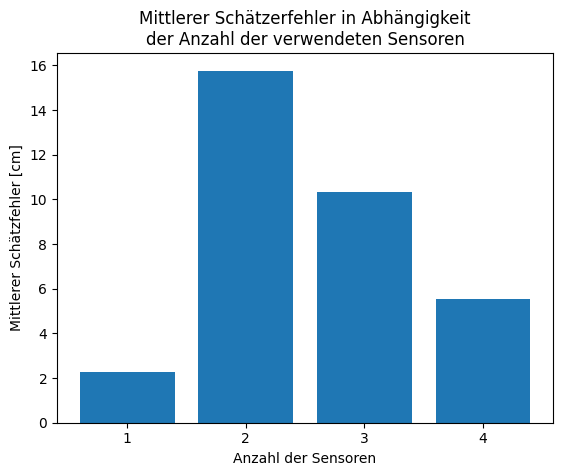

In [82]:
sensoranzahlen = []
alle_fusionsfehler = []
for ANZ_SENSOREN in range(1,5):
    fusionsfehler = exp(ANZ_SENSOREN, zeige_details=False)
    sensoranzahlen.append(ANZ_SENSOREN)
    alle_fusionsfehler.append( fusionsfehler )

import matplotlib.pyplot as plt
plt.bar(sensoranzahlen, alle_fusionsfehler)
plt.xlabel("Anzahl der Sensoren")
plt.ylabel("Mittlerer Schätzfehler [cm]")
plt.xticks(sensoranzahlen)
plt.title("Mittlerer Schätzerfehler in Abhängigkeit\n" +
          "der Anzahl der verwendeten Sensoren")
plt.show()

# Simulation eines echt fiesen Abstandssensors

## Seltsame Kennlinie erzeugen

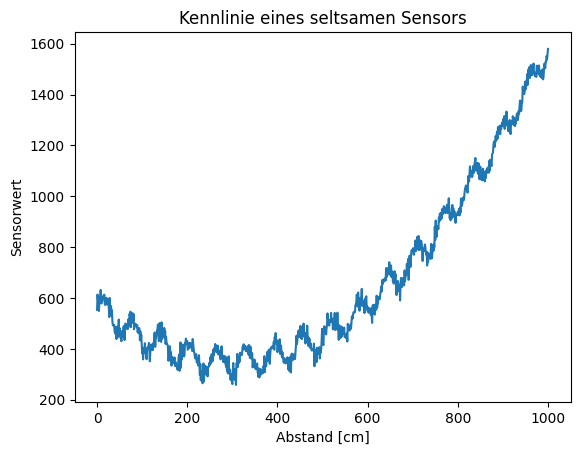

In [83]:
import numpy
import matplotlib.pyplot as plt

bias = -50
noise = 20
pos = 500

abstaende = []
sensorwerte = []
for abstand in range(0,1001):
    sensorwert = abstand + \
                 50*numpy.sin(abstand/10) + \
                 numpy.random.normal(loc=bias, scale=noise) + ((abstand-pos)/20)**2
    
    abstaende.append(abstand)
    sensorwerte.append(sensorwert)
    
plt.plot(abstaende,sensorwerte)
plt.title("Kennlinie eines seltsamen Sensors")
plt.xlabel("Abstand [cm]")
plt.ylabel("Sensorwert")
plt.show()

## Neue Sensorklasse

In [84]:
class sensor_strange:
    
    def __init__(self, bias, noise, pos):
        self.bias = bias
        self.noise = noise
        self.pos = pos
        
    def gib_mir_sensorwert(self, x):        
        sensorwert = x + 50*numpy.sin(x/10) + numpy.random.normal(loc=bias, scale=noise) + ((x-self.pos)/20)**2
        return sensorwert
    
    def gib_mir_kennlinien_daten(self):
        abstaende = []
        sensorwerte = []
        for abstand in range(0,1000):
            sensorwert = self.gib_mir_sensorwert(abstand)
            abstaende.append(abstand)
            sensorwerte.append(sensorwert)
        return abstaende, sensorwerte
    
    def zeige_sensor_kurve(self):
        abstaende, sensorwerte = self.gib_mir_kennlinien_daten()
        plt.plot(abstaende,sensorwerte)
        plt.xlabel("Tatsächlicher Abstand (Grundwahrheit)")
        plt.ylabel("Sensorwert")
        plt.show()  

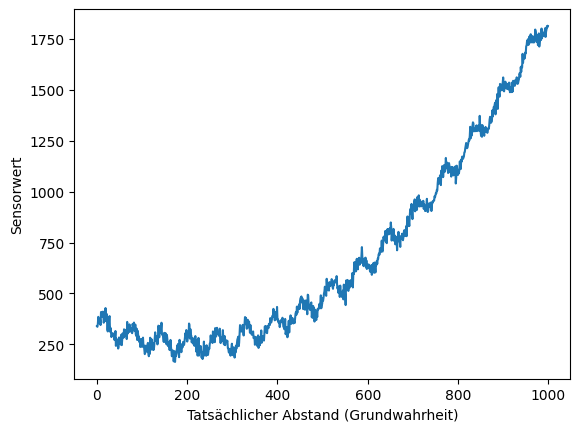

In [85]:
s1 = sensor_strange(-50,20,400)
s1.zeige_sensor_kurve()

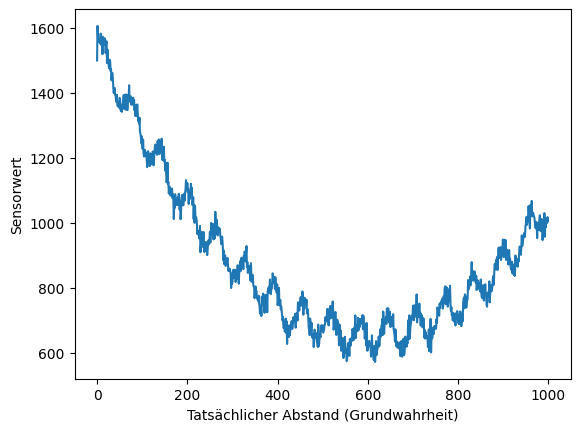

In [86]:
s2 = sensor_strange(-50,20,800)
s2.zeige_sensor_kurve()

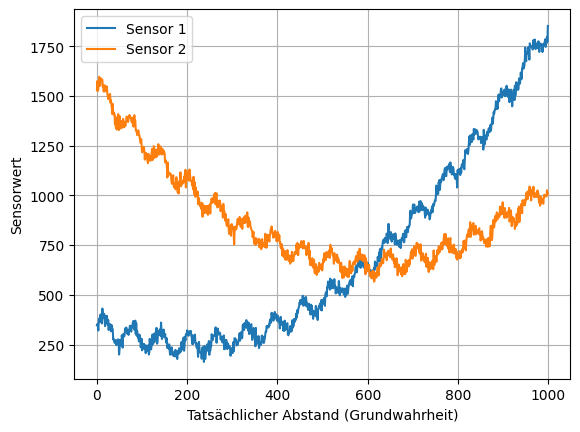

In [87]:
a1,sw1 = s1.gib_mir_kennlinien_daten()
a2,sw2 = s2.gib_mir_kennlinien_daten()
plt.plot(a1,sw1, label="Sensor 1")
plt.plot(a2,sw2, label="Sensor 2")
plt.xlabel("Tatsächlicher Abstand (Grundwahrheit)")
plt.ylabel("Sensorwert")
plt.legend()
plt.grid()
plt.show() 

# Eine lernende Sensordatenfusion

## Einleitung: Wieso Machine Learning?

Problem / Herausforderung: wir müssen nun damit umgehen, dass ein "einfaches" Inverses Sensormodell (ISM) über eine Look-Up-Table nicht mehr möglich ist.

Ein bestimmte Messwert, z.B. 300 kann bei den Sensoren nämlich bei verschiedenen Distanzen vorkommen.

Wir lernen dazu über "Machine Learning" ein Inverses Sensor Modell, das einen Messvektor **z** auf einen Zustandsvektor **x** abbildet.

## Vorbereiten der Beispieldaten fürs Machine Learning

In [88]:
X = numpy.zeros( (1000,2) )
Y = numpy.zeros( (1000,1) )

i = 0
for abstand in range(0,1000):
    sensorwert_s1 = s1.gib_mir_sensorwert(abstand)
    sensorwert_s2 = s2.gib_mir_sensorwert(abstand)
    
    X[i,:] = numpy.array( [sensorwert_s1, sensorwert_s2] )
    Y[i,0] = abstand
    
    i += 1

In [89]:
X.shape

(1000, 2)

In [90]:
Y.shape

(1000, 1)

In [91]:
X[0:5]

array([[ 313.53267562, 1566.23881123],
       [ 345.79795079, 1554.45568454],
       [ 387.93590899, 1549.24940829],
       [ 363.36018403, 1548.08698049],
       [ 357.48809173, 1558.90850645]])

In [92]:
Y[0:5]

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.]])

## Beispieldaten aufspalten in Trainings- und Testdaten

In [93]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,
                                                    random_state = 0)

In [94]:
x_train.shape

(800, 2)

In [95]:
x_train[0:5]

array([[ 830.87528532,  637.22224604],
       [ 455.10689314,  664.17093403],
       [ 356.29130931,  857.38986394],
       [1734.38605331,  968.10465827],
       [1222.27180307,  779.98251773]])

In [96]:
y_train[0:5]

array([[687.],
       [500.],
       [332.],
       [979.],
       [817.]])

In [97]:
x_test.shape

(200, 2)

In [98]:
y_test.shape

(200, 1)

## Machine Learning mittels scikit-learn

In [99]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3, weights="uniform")
knn = knn.fit(x_train, y_train)

## Testen der Modellgüte

In [100]:
y_pred_test = knn.predict( x_test )

In [101]:
y_pred_test[0:5]

array([[976.33333333],
       [849.66666667],
       [295.66666667],
       [553.        ],
       [687.33333333]])

In [102]:
y_test[0:5]

array([[993.],
       [859.],
       [298.],
       [553.],
       [672.]])

In [103]:
y_pred_test.shape

(200, 1)

In [104]:
y_test.shape

(200, 1)

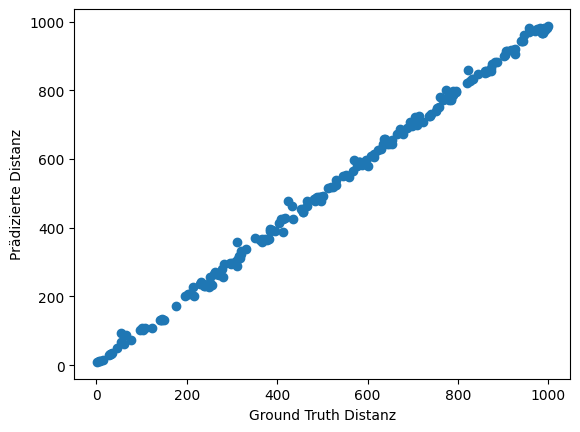

In [105]:
plt.scatter(y_test.flatten(), y_pred_test.flatten())
plt.xlabel("Ground Truth Distanz")
plt.ylabel("Prädizierte Distanz")
plt.show()

In [106]:
MAE( y_test.flatten(), y_pred_test.flatten() )

8.81

# Lernende Ansätze zur Fusion von Sensordaten unterschiedlicher Ranges

## Eine neue Sensorklasse

In [107]:
class sensor_strange_range:
    
    def __init__(self, bias, noise, pos, fac):
        self.bias = bias
        self.noise = noise
        self.pos = pos
        self.fac = fac
        
    def gib_mir_sensorwert(self, x):        
        sensorwert = self.fac * (x + 50*numpy.sin(x/10) + numpy.random.normal(loc=bias, scale=noise) + ((x-self.pos)/20)**2)
        return sensorwert
    
    def gib_mir_kennlinien_daten(self):
        abstaende = []
        sensorwerte = []
        for abstand in range(0,1000):
            sensorwert = self.gib_mir_sensorwert(abstand)
            abstaende.append(abstand)
            sensorwerte.append(sensorwert)
        return abstaende, sensorwerte
    
    def zeige_sensor_kurve(self):
        abstaende, sensorwerte = self.gib_mir_kennlinien_daten()
        plt.plot(abstaende,sensorwerte)
        plt.xlabel("Tatsächlicher Abstand (Grundwahrheit)")
        plt.ylabel("Sensorwert")
        plt.show() 

In [112]:
s1 = sensor_strange_range(-50,20,400, 1)
s2 = sensor_strange_range(-50,20,800, 10)

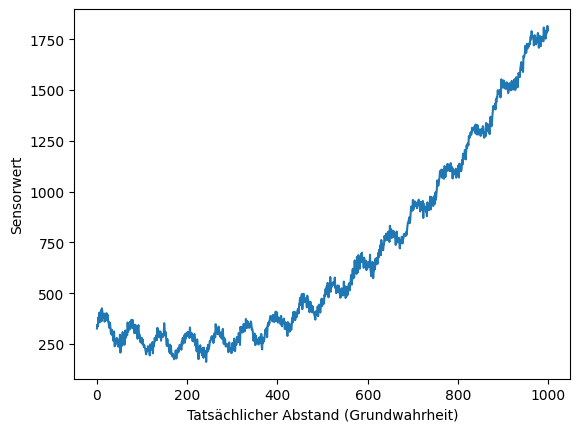

In [113]:
s1.zeige_sensor_kurve()

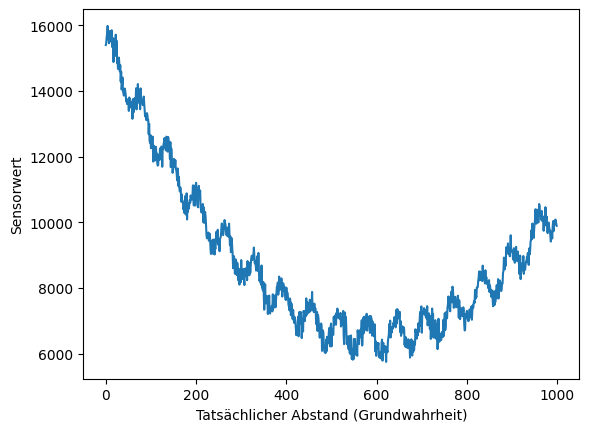

In [114]:
s2.zeige_sensor_kurve()

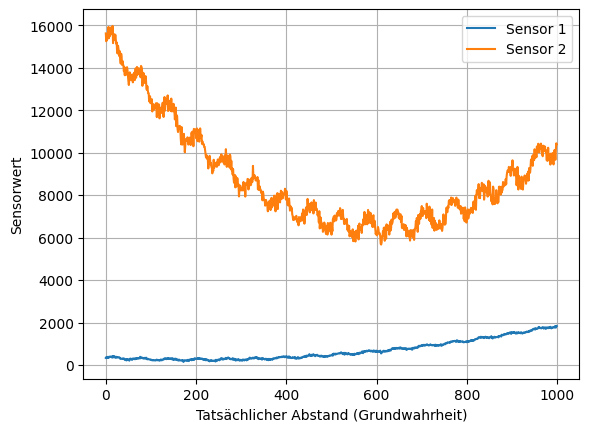

In [115]:
a1,sw1 = s1.gib_mir_kennlinien_daten()
a2,sw2 = s2.gib_mir_kennlinien_daten()
plt.plot(a1,sw1, label="Sensor 1")
plt.plot(a2,sw2, label="Sensor 2")
plt.xlabel("Tatsächlicher Abstand (Grundwahrheit)")
plt.ylabel("Sensorwert")
plt.legend()
plt.grid()
plt.show()

## Machine Learning Reloaded

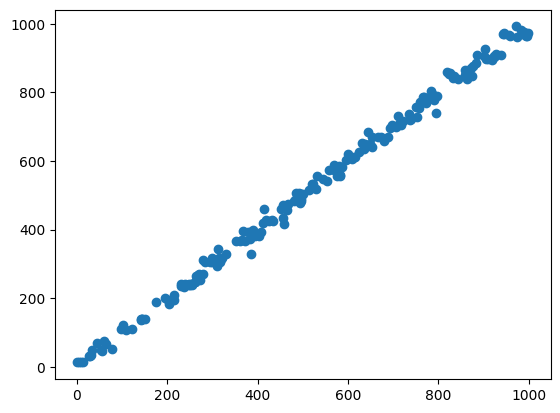

MAE= 12.43


In [141]:
# 1. Beispieldaten fürs ML vorbereiten
X = numpy.zeros( (1000,2) )
Y = numpy.zeros( (1000,1) )
i = 0
for abstand in range(0,1000):
    sensorwert_s1 = s1.gib_mir_sensorwert(abstand)
    sensorwert_s2 = s2.gib_mir_sensorwert(abstand)
    X[i,:] = numpy.array( [sensorwert_s1, sensorwert_s2] )
    Y[i,0] = abstand
    i += 1


# 2. Beispieldaten in Trainings- und Testdaten aufteilen
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,
                                                    random_state = 0)


# 3. k-NN Regressor erlernen
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3, weights="uniform")
knn = knn.fit(x_train, y_train)


# 4. Modellgüte ermitteln
y_pred_test = knn.predict( x_test )


# 5. Plotten der Prädiktionen
plt.scatter(y_test.flatten(), y_pred_test.flatten())
plt.show()


# 6. Quantitative Auswertung des mittleren Fehlers
print( "MAE=", MAE( y_test.flatten(), y_pred_test.flatten() ) )

Man sieht, dass der Fehler deutlich größer geworden ist! Der Grund ist, dass der k-NN Regressor nun nicht mehr mit dem Standardabstandsmaß (euklidische Maß) funktioniert. Wir müssen dazu vorher die Sensormesswerte normalisieren!

## Normalisierung

In [130]:
D = numpy.array( [[-20,-2],
                  [-20,-1],
                  [  0, 0],
                  [+10,+1],
                  [+20,+2]] )

In [131]:
D

array([[-20,  -2],
       [-20,  -1],
       [  0,   0],
       [ 10,   1],
       [ 20,   2]])

In [132]:
numpy.mean( D[:,0] )

-2.0

In [133]:
numpy.std( D[:,0] )

16.0

In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
D_scaled = scaler.fit_transform(D)

In [135]:
D_scaled

array([[-1.125     , -1.41421356],
       [-1.125     , -0.70710678],
       [ 0.125     ,  0.        ],
       [ 0.75      ,  0.70710678],
       [ 1.375     ,  1.41421356]])

In [136]:
D_scaled[:,0]

array([-1.125, -1.125,  0.125,  0.75 ,  1.375])

In [137]:
numpy.mean( D_scaled[:,0] )

0.0

In [138]:
numpy.std( D_scaled[:,0] )

1.0

## Jetzt ML mit Skalierung der Sensordaten

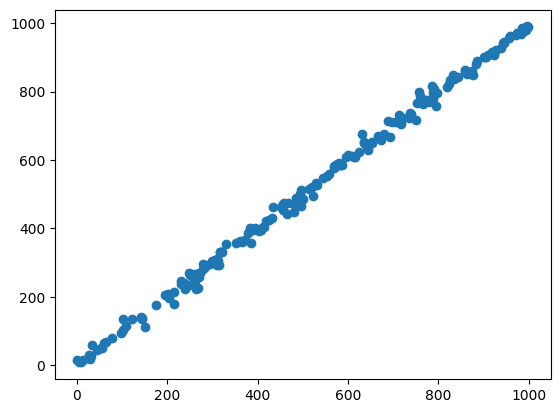

MAE = 9.85cm


In [142]:
# 1. Beispieldaten fürs ML vorbereiten
X = numpy.zeros( (1000,2) )
Y = numpy.zeros( (1000,1) )
i = 0
for abstand in range(0,1000):
    sensorwert_s1 = s1.gib_mir_sensorwert(abstand)
    sensorwert_s2 = s2.gib_mir_sensorwert(abstand)
    X[i,:] = numpy.array( [sensorwert_s1, sensorwert_s2] )
    Y[i,0] = abstand
    i += 1


# 2. Beispieldaten in Trainings- und Testdaten aufteilen
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


# 3. Skalierung der Trainings- und Testdaten
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)


# 4. k-NN Regressor erlernen
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=3, weights="uniform")
knn = knn.fit(x_train_scaled, y_train)


# 5. Modellgüte ermitteln
y_pred_test = knn.predict( x_test_scaled )


# 6. Plotten der Prädiktionen
plt.scatter(y_test.flatten(), y_pred_test.flatten())
plt.show()


# 7. Quantitative Auswertung des mittleren Fehlers
fehler = MAE( y_test.flatten(), y_pred_test.flatten() )
print( f"MAE = {fehler:.2f}cm" )

Wir konnten jetzt den mittleren absoluten Schätzfehler zur Entfernungsschätzung auf Basis zweier Sensorwerte wieder auf ca. 10cm reduzieren.

# Mehrere Sensoren erzeugen

In [143]:
bias = numpy.random.uniform(low=-100, high=100)
var  = numpy.random.uniform(low=1, high=100)
pos  = numpy.random.uniform(low=1, high=1000)
fac  = numpy.random.uniform(low=1, high=100)
bias, var, pos, fac

(44.55538846473459, 59.65750729864127, 163.25621713141322, 38.98018675483435)

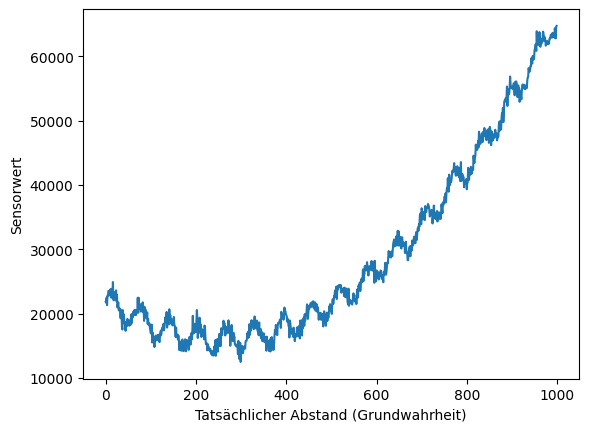

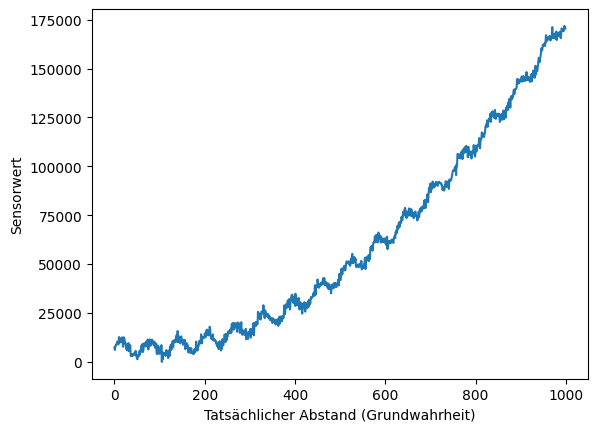

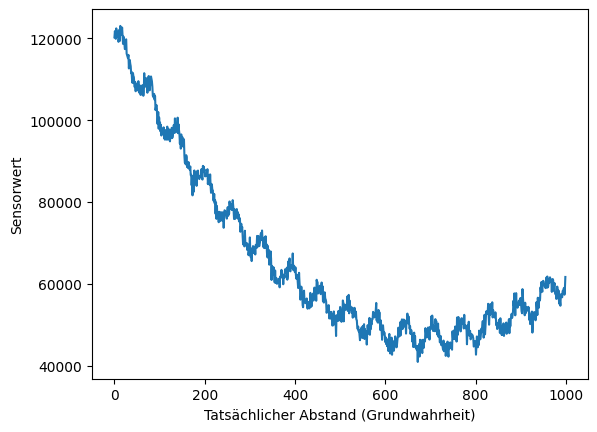

In [144]:
nr_sensors = 3
for sensor_nr in range(nr_sensors):
    bias = numpy.random.uniform(low=-100, high=100)
    var  = numpy.random.uniform(low=1, high=100)
    pos  = numpy.random.uniform(low=1, high=1000)
    fac  = numpy.random.uniform(low=1, high=100)
    s = sensor_strange_range(bias, var, pos, fac)
    s.zeige_sensor_kurve()

In [145]:
def erzeuge_sensoren(nr_sensors, diagrams=True):
    sensors = []
    for sensor_nr in range(nr_sensors):
        bias = numpy.random.uniform(low=-100, high=100)
        var  = numpy.random.uniform(low=1, high=100)
        pos  = numpy.random.uniform(low=1, high=1000)
        fac  = numpy.random.uniform(low=1, high=100)
        s = sensor_strange_range(bias, var, pos, fac)
        if diagrams:
            s.zeige_sensor_kurve()        
        sensors.append(s)
    return sensors

# Sensordatenfusion mit steigender Anzahl von Sensoren

In [148]:
def experiment(nr_sensors, diagrams=False):

    # 1. Erzeuge Sensoren
    sensors = erzeuge_sensoren(nr_sensors, diagrams)

    # 2. Beispieldaten fürs ML vorbereiten
    X = numpy.zeros( (1000,nr_sensors) )
    Y = numpy.zeros( (1000,1) )
    i = 0
    for e in range(0,1000):

        for sensor_nr, sensor in enumerate(sensors):
            sensorwert = sensor.gib_mir_sensorwert(e)
            X[i,sensor_nr] = sensorwert

        Y[i,0] = e 
        i += 1


    # 2. Beispieldaten in Trainings- und Testdaten aufteilen
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


    # 3. Skalierung der Trainings- und Testdaten
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled  = scaler.transform(x_test)


    # 4. k-NN Regressor erlernen
    from sklearn.neighbors import KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors=3, weights="uniform")
    knn = knn.fit(x_train_scaled, y_train)


    # 5. Modellgüte ermitteln
    y_pred_test = knn.predict( x_test_scaled )


    # 6. Plotten der Prädiktionen
    if diagrams:
        plt.scatter(y_test.flatten(), y_pred_test.flatten())
        plt.show()


    # 7. Quantitative Auswertung des mittleren Fehlers
    fehler = MAE( y_test.flatten(), y_pred_test.flatten() )
    print( f"nr_sensors={nr_sensors} -> MAE = {fehler:.2f}cm" )
    return fehler

In [149]:
ergebnisse_x = []
ergebnisse_y = []
for nr_sensors in range(2,11):
    
    alle_fehler = []
    for run in range(50):
        fehler = experiment(nr_sensors)
        alle_fehler.append(fehler)
        
    ergebnisse_x.append( nr_sensors )
    ergebnisse_y.append( numpy.mean(alle_fehler) )

nr_sensors=2 -> MAE = 5.61cm
nr_sensors=2 -> MAE = 8.34cm
nr_sensors=2 -> MAE = 33.16cm
nr_sensors=2 -> MAE = 27.89cm
nr_sensors=2 -> MAE = 7.59cm
nr_sensors=2 -> MAE = 4.85cm
nr_sensors=2 -> MAE = 9.53cm
nr_sensors=2 -> MAE = 6.32cm
nr_sensors=2 -> MAE = 14.97cm
nr_sensors=2 -> MAE = 18.58cm
nr_sensors=2 -> MAE = 8.07cm
nr_sensors=2 -> MAE = 6.59cm
nr_sensors=2 -> MAE = 48.85cm
nr_sensors=2 -> MAE = 16.84cm
nr_sensors=2 -> MAE = 12.38cm
nr_sensors=2 -> MAE = 28.11cm
nr_sensors=2 -> MAE = 35.69cm
nr_sensors=2 -> MAE = 8.58cm
nr_sensors=2 -> MAE = 11.76cm
nr_sensors=2 -> MAE = 5.12cm
nr_sensors=2 -> MAE = 5.13cm
nr_sensors=2 -> MAE = 7.04cm
nr_sensors=2 -> MAE = 7.21cm
nr_sensors=2 -> MAE = 5.95cm
nr_sensors=2 -> MAE = 113.68cm
nr_sensors=2 -> MAE = 8.07cm
nr_sensors=2 -> MAE = 12.11cm
nr_sensors=2 -> MAE = 12.80cm
nr_sensors=2 -> MAE = 20.68cm
nr_sensors=2 -> MAE = 5.54cm
nr_sensors=2 -> MAE = 36.15cm
nr_sensors=2 -> MAE = 7.47cm
nr_sensors=2 -> MAE = 17.32cm
nr_sensors=2 -> MAE = 6.68

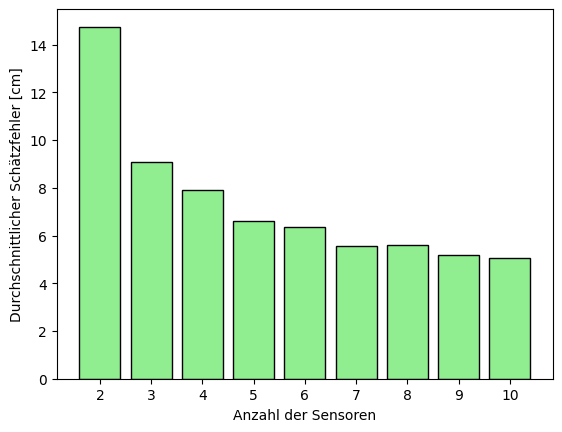

In [156]:
plt.bar(ergebnisse_x, ergebnisse_y, color="lightgreen", edgecolor="black")
plt.xlabel("Anzahl der Sensoren")
plt.ylabel("Durchschnittlicher Schätzfehler [cm]")
plt.xticks(ergebnisse_x)
plt.show()